# Incremental decomposition scheme for mechanosoprtive strain calculation
#### *A. Ferrara and F.K. Wittel "Mechanosorptive Creep of Norway Spruce on the Tissue Scale Perpendicular to Grain"*, *Holzforschung* (2025)

This notebook implements and tests the incremental decomposition scheme proposed in *Ferrara and Wittel (2025b)* on calculated clean data to isolate mechanosorptive creep strain, using the **_MS_Creep_Tests_Dataset_** ([10.17632/rsrsw8h7mv.1]()).  

The dataset includes the results of:  
- **Tensile elastic tests** on **Norway spruce tissue slices** in all anatomical orientations (longitudinal L, radial R, tangential T) and combinations **{LR, RL, RT, TR, LT}** (first letter = length, second = width). Tests were performed at **relative humidity (RH)** levels of 30%, 65%, and 90%, corresponding to **moisture contents (mc)** of 0.07, 0.12, and 0.20, respectively.  
- **Tensile creep tests** on the same tissue slice orientations and moisture conditions.
- **Dynamic Vapor Sorption (DVS) tests** on a RL-slice, following the RH profile applied in the mechanosorptive experiments.

### Imports and working path
Run the following section to import the required libraries and download the data folder in the current directory.

In [1]:
import os
import ast
import requests
import zipfile
from math import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from scipy.optimize import lsq_linear
from scipy.optimize import least_squares
from scipy.interpolate import UnivariateSpline
import matplotlib.ticker as mticker

# Download dataset in the current folder
url = "https://data.mendeley.com/public-files/datasets/rsrsw8h7mv/files/c74b8815-a92e-4921-975b-47f9dcebeb3d/file_downloaded" # Link to dataset folder
extraction_path = os.getcwd()  # path to current folder
zip_file_path = os.path.join(extraction_path, "downloaded_folder.zip")  # path to folder where the zip file will be saved
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36"} # get headers (optional, but recommended for some sites)
response = requests.get(url, headers=headers) # get response from URL
if response.status_code == 200:
    with open(zip_file_path, "wb") as f:  # download the zip file
        f.write(response.content)   
    try:
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:  # unzip the file
            zip_ref.extractall(extraction_path)
        extracted_file = zip_ref.namelist()[0]  # name of the extracted folder
        folder_path = os.path.join(extraction_path, extracted_file) # path to dataset folder
        print(f"Working in: {folder_path}")
        os.remove(zip_file_path)  # remove the downloaded zip file
    except zipfile.BadZipFile:
        print("Error: The file is not a zip file or it is corrupted.")
else:
    print(f"Failed to download. Status code: {response.status_code}")

# Set file paths
dvs_path = folder_path + 'dvs_data.npz'
elastic_path = folder_path + 'elastic_compliances_Ferrara_Wittel_2024.csv'
viscoel_path = folder_path + 'master_vec_prony_param.csv'

Working in: C:\Users\Falk\Documents\MS_Creep_Tests_Dataset/


### Customized functions
Run the following section to make the custom functions available for use in the rest of the notebook.

In [2]:
# Set same number of thicks on twin axes
def match_tick_count(ax_src, ax_tgt, axis='y'):
    if axis not in ('x','y'):
        raise ValueError("`axis` must be 'x' or 'y'")

    # Pick off the existing tick *locations* on the source axis
    if axis == 'x':
        n = len(ax_src.get_xticks())-1
        locator = mticker.MaxNLocator(n)
        ax_tgt.xaxis.set_major_locator(locator)
    else:
        n = len(ax_src.get_yticks())-1
        locator = mticker.MaxNLocator(n)
        ax_tgt.yaxis.set_major_locator(locator)
    return
# end: def match_tick_count

# Set same tick values on twin axes
def match_tick_values(ax_src, ax_tgt, axis='y', copy_labels=True, copy_limits=True):
    if axis not in ('x','y'):
        raise ValueError("`axis` must be 'x' or 'y'")
    # 1) Optionally copy axis limits
    if copy_limits:
        if axis == 'y':
            ax_tgt.set_ylim(ax_src.get_ylim())
        else:
            ax_tgt.set_xlim(ax_src.get_xlim())

    # 2) Grab the *exact* tick positions
    if axis == 'y':
        ticks = ax_src.get_yticks()
        # use a FixedLocator so Matplotlib doesn't try to autoscale them away
        ax_tgt.yaxis.set_major_locator(mticker.FixedLocator(ticks))
        if copy_labels:
            labels = [t.get_text() for t in ax_src.get_yticklabels()]
            ax_tgt.set_yticklabels(labels)
    else:
        ticks = ax_src.get_xticks()
        ax_tgt.xaxis.set_major_locator(mticker.FixedLocator(ticks))
        if copy_labels:
            labels = [t.get_text() for t in ax_src.get_xticklabels()]
            ax_tgt.set_xticklabels(labels)
    return
# end: def match_tick_values

# Set shared grid between primary and secondary y-axis
def set_shared_grid(ax1, ax2):

    # 1) grab the current primary ticks
    primary_ticks = ax1.get_yticks()
    # 2) extend the primary limits by one step on each end
    new_bottom = primary_ticks[0]
    new_top = primary_ticks[-1]
    ax1.set_ylim(new_bottom, new_top)
    # 3) keep the same gridlines at the primary_ticks
    ax1.set_yticks(primary_ticks)
    # 4) now compute secondary ticks by slicing its data‐range into len(primary_ticks) points
    smin, smax = ax2.get_ylim()
    secondary_ticks = np.linspace(smin, smax, len(primary_ticks))
    ax2.set_yticks(secondary_ticks)
    ax2.set_yticklabels([str(round(t,3)) for t in secondary_ticks])

    return
# end: def set_shared_grid

# Convert RH into mean w (mean S/D of tissues from standard dvs test)
def RH_to_w_mean(x):
    w = 7.155e-11 * x**5 - 1.659e-08 * x**4 + 1.75e-06 * x**3 - 9.343e-05 * x**2 + 0.003795 * x + 0.002295
    return w
# end: RH_to_w_mean

# Calculate hygroexpansion strain
def calculate_hygroexp_strain(sample_type, wdata):

    # Set hygroexpansion coefficients
    alpha = {"R": 0.182,
            "T": 0.343,
            "L": 0.0061}
    # Extract loading direction
    long_dir = sample_type[0]
    # Calculate hygroexpansion strain
    eps_w = alpha[long_dir]*(wdata-wdata[0])

    return eps_w
# end: def calculate_hygroexp_strain

# Fit elastic compliances to moisture
def fit_elastic_comp(elastic_path):

    # Read csv file
    df = pd.read_csv(elastic_path)
    # Group and compute mean compliance
    mean_df = df.rename(columns={'1/C0 [1/Mpa]': 'C0_mean'})
    # Calculate average w for each RH
    mean_df['w'] = RH_to_w_mean(mean_df['RH'])
    # Fit quadratic function in w
    el_fits = {}
    for stype, sub in mean_df.groupby('sample_type'):
        x = sub['w'].values
        y = sub['C0_mean'].values
        A = np.vstack(( x**2, x, np.ones_like(x) )).T
        # choose bounds per sample_type
        if stype in ("LR", "LT-LW"):
            lower = [-np.inf, 0.0,     0.0]
            upper = [ 0.0,     np.inf, np.inf]
        else:
            lower = [ 0.0,     0.0,     0.0]
            upper = [ np.inf, np.inf, np.inf]
        # Solve
        res = lsq_linear(A, y, bounds=(lower, upper))
        a, b, c = res.x
        el_fits[stype] = (a, b, c)

    return el_fits
# end: fit_elastic_comp

# Calculate elastic strain
def calculate_elastic_strain(comp_el, sample_type, stress, wdata, load=True):

    N = len(wdata)
    eps_el = [0.0] * N

    if not load:
        # All zeros if not loading
        return eps_el

    # Extract the three coefficients for compliance calculation: a, b, c
    a, b, c = comp_el[sample_type]

    for i in range(N):
        # Compute compliance at wdata[i]
        C_i = a * wdata[i]**2 + b * wdata[i] + c
        # Instantaneous elastic strain = compliance * stress
        eps_el[i] = C_i * stress[i]

    return eps_el
# end: def calculate_elastic_strain

# Fit viscoelastic compliances (prony coeff.) to moisture
def fit_viscoelastic_comp(viscoel_path):

    # Read csv file
    df = pd.read_csv(viscoel_path, sep=",", dtype={"sample_type": str, "RH": float, "avg_comp_i": str})
    # Parse string‐list into float-list
    df["comp_i"] = df["avg_comp_i"].apply(lambda s: [float(x) for x in ast.literal_eval(s)])
    # Calculate average w for each RH
    df["w"] = RH_to_w_mean(df["RH"]) 
    # Fit quadratic function in w
    ve_fits = {}
    for stype, sub in df.groupby("sample_type"):
        w_vals = sub["w"].values
        C = np.vstack(sub["comp_i"].values)
        polys = [np.polyfit(w_vals, C[:, j], 2) for j in range(C.shape[1])]
        ve_fits[stype] = polys

    return ve_fits
# end: def fit_viscoelastic_comp

# Calculate prony series
def prony_response(comp_i, tdata, tau_0):
    return (np.sum(comp_i) - np.sum(comp_i[:, None] * np.exp(-tdata / tau_0[:, None]), axis=0))
# end: def prony_response

# Calculate prony coefficients at w
def comp_i_at_w(comp_ve, stype, wval):
    polys = comp_ve[stype]
    return np.array([ np.polyval(p, wval) for p in polys ])
# end: def comp_i_at_w

# Calculate viscoelastic creep compliance at given time and w
def compliance_at_t_w(comp_ve, stype, tdata, wval, tau_0):
    c_i = comp_i_at_w(comp_ve, stype, wval)
    return prony_response(c_i, tdata, tau_0)
# end: def compliance_at_t_w

# Calculate viscoelastic strain
def calculate_viscoelastic_strain(comp_ve, sample_type, stress, tdata, wdata, eps_el0):

    # Set retardation times [h]
    tau_0 = np.array([0.1, 1., 10., 100.])
    # Calculate viscoelastic strain
    eps_ve = []
    eps_i = np.zeros(tau_0.shape)
    eps_ve.append(eps_el0)
    for i in range(1, len(tdata)):
        # Calculate viscoelastic strain components
        comp_i_n1 = comp_i_at_w(comp_ve, sample_type, wdata[i])
        comp_i_n0 = comp_i_at_w(comp_ve, sample_type, wdata[i-1])
        comp_i = (comp_i_n1 + comp_i_n0) /2.
        deps_ve = np.zeros(tau_0.shape)
        deps_ve = 1. / tau_0 * (comp_i * stress[i] - eps_i)
        eps_i += deps_ve * (tdata[i]-tdata[i-1])
        eps_ve.append(np.sum(eps_i)+eps_el0)

    return eps_ve
# end: def calculate_viscoelastic_strain

# Compute incremental strains across cycles
def compute_segment_deltas(tdata, edata, wdata, sdata, cycle_idx, n_segments=1000):

    # Initialize arrays
    seg_times = []
    seg_vals = []
    seg_stress = []
    seg_moist = []
    
    for i, end in enumerate(cycle_idx):
        # Set previous cycle
        start = -1 if i == 0 else cycle_idx[i-1]
        # Extract time
        t_c = tdata[start+1:end+1]
        rel = t_c - t_c[0]
        markers = np.linspace(0, rel[-1], n_segments)
        t_marks = markers + t_c[0]
        seg_times.append(t_marks)
        # Extract stress
        s_c = sdata[start+1:end+1]
        s_marks = UnivariateSpline(t_c, s_c, k=5, s=0)(t_marks)
        seg_stress.append(s_marks)
        # Extract moisture
        w_c = wdata[start+1:end+1]
        w_marks = UnivariateSpline(t_c, w_c, k=5, s=0)(t_marks)
        seg_moist.append(w_marks)
        # Extract strain
        e_c = edata[start+1:end+1]
        e_marks = UnivariateSpline(t_c, e_c, k=5, s=0)(t_marks)
        seg_vals.append(e_marks)

    # Convert to arrays
    seg_times = np.array(seg_times)
    seg_vals = np.array(seg_vals)
    seg_moist = np.array(seg_moist)
    seg_stress = np.array(seg_stress)

    # Calculate delta strain
    delta_s = seg_vals[1:] - seg_vals[:-1]

    return seg_times, delta_s, seg_moist, seg_stress
# end: compute_segment_deltas

# Find stress drop
def find_local_drop(arr, stress_drop=None, window=5):
    # Compute all differences
    arr = np.asarray(arr)
    n   = arr.size
    if n < 2: raise ValueError("Array must have at least 2 elements to find a drop.")
    diffs = np.diff(arr)
    
    if stress_drop is None:
        # No guess, but global search
        return int(np.argmin(diffs)) + 1

    # Clamp stress_drop to valid [0, n-1]
    sd = int(np.clip(stress_drop, 0, n - 1))
    # Convert to diffs‐index domain: diffs[j] = arr[j+1] - arr[j]
    # so arr‐index i corresponds to diffs‐index j = i-1
    j_center = sd - 1

    # Define window in diffs‐space
    j0 = max(0,     j_center - window)
    j1 = min(n - 2, j_center + window)
    local = diffs[j0:j1+1]
    if local.size:
        j_drop = j0 + int(np.argmin(local))
        return j_drop + 1 

    return int(np.argmin(diffs)) + 1
# end: def find_local_drop

# Calculate mechanosorptive strain from incremental scheme
def calculate_mechanosorptive_strain_from_inc(wdata, tdata, sdata, edata, cycle_idx, firstc_l, lastc_l, firstc_un=None, lastc_un=-1):
    
    ########## Calculate strain increments ##########
    # Find strain templates
    [t_cycle, eps_cycle], [t_cycle1, eps_cycle1] = analyze_cycles(tdata, wdata, edata, cycle_idx, firstc=firstc_l, lastc=lastc_l)
    # Compute incremental strains
    seg_times, delta_e, seg_moist, seg_stress = compute_segment_deltas(tdata, edata, wdata, sdata, cycle_idx)

    ########## Correct jump of template I (1st cycle) ##########
    # get corresponding moisture and time
    w_end = seg_moist[0][-1]
    w_temp = seg_moist[0][:len(seg_moist[0])//2]
    idx = np.abs(w_temp - w_end).argmin()
    t_start = seg_times[0][idx]
    idx_t = np.abs(t_cycle - t_start).argmin()

    # Find delta strain
    delta_end = eps_cycle[-1] - eps_cycle[idx_t]
    x1, y1 = t_cycle[0], 0
    x2, y2 = t_cycle[-1], delta_end
    m0 = (y2 - y1) / (x2 - x1)
    b0 = y1 - m0 * x1
    # Shift jump by linear scaling
    shift_cycle = m0*t_cycle + b0 
    eps_cycle = eps_cycle - shift_cycle

    ########## Calculate mechanosorp. strain of 1st cycle ##########
    # Build temporary strain of first cycle
    first_cycle = UnivariateSpline(t_cycle, eps_cycle, k=5, s=0)(seg_times[0])
    shift = first_cycle[0] - edata[0]
    first_cycle = first_cycle - shift
    # Evaluate first cycle at given segmented times
    idx = np.searchsorted(tdata, seg_times[0], side='left')
    idx = np.clip(idx, 0, len(tdata)-1)
    prev = np.clip(idx-1, 0, len(tdata)-1)
    choose_prev = np.abs(tdata[prev] - seg_times[0]) <= np.abs(tdata[idx] - seg_times[0])
    idx[choose_prev] = prev[choose_prev]
    # Extract mechanosorptive strain of first cycle
    first_cycle_ms = edata[idx] - first_cycle

    ########## Correct jump of template II (from 2nd cycle) ##########
    # Find delta strain
    delta_end = eps_cycle1[-1] - eps_cycle1[0]
    x1, y1 = t_cycle[0], eps_cycle1[0] - eps_cycle1[0]
    x2, y2 = t_cycle[-1], delta_end
    m1 = (y2 - y1) / (x2 - x1)
    b1 = y1 - m1 * x1
    # Shift jump by linear scaling
    shift_cycle = m1*t_cycle + b1
    eps_cycle1 = eps_cycle1 - shift_cycle

    ########## Correct templates (II - I) ##########
    second_cycle = UnivariateSpline(t_cycle, eps_cycle1, k=5, s=0)(seg_times[0])
    inc_vals = []
    inc_vals.append(first_cycle_ms)
    for i,d in enumerate(cycle_idx):
        if i > 0:
            # Evaluate cycle at given segmented times
            idx = np.searchsorted(tdata, seg_times[i], side='left')
            idx = np.clip(idx, 0, len(tdata)-1)
            prev = np.clip(idx-1, 0, len(tdata)-1)
            choose_prev = np.abs(tdata[prev] - seg_times[0]) <= np.abs(tdata[idx] - seg_times[0])
            idx[choose_prev] = prev[choose_prev]
            epsP = edata[idx]
            shift = second_cycle[0] - epsP[0]
            inc_vals.append(epsP - second_cycle + shift + inc_vals[-1][-1])
    eps_flat  = np.concatenate(inc_vals)


    if firstc_un is not None:
        ########## Find stress drop ##########
        # Find stress drop
        stress_flat = np.concatenate(seg_stress)
        drop_idx_flat = find_local_drop(stress_flat)
        # Fit unloaded cycles
        _, [t_end, eps_end] = analyze_cycles(tdata, wdata, edata, cycle_idx, firstc=firstc_un, lastc=lastc_un)
        ########## Correct jump of template III (last cycle) ##########
        delta_end = eps_end[-1] - eps_end[0]
        x1, y1 = t_cycle[0], eps_end[0] - eps_end[0]
        x2, y2 = t_cycle[-1], delta_end
        m = (y2 - y1) / (x2 - x1)
        b = y1 - m * x1
        shift_cycle = m*t_cycle + b 
        eps_end = eps_end - shift_cycle
        ########## Correct strain for unloading ##########
        # Build temporary strain of last cycle
        last_cycle = UnivariateSpline(t_end, eps_end, k=5, s=0)(seg_times[0])
        shift = last_cycle[0]
        last_cycle = last_cycle - shift

        M = seg_stress[0].shape[0]
        drop_cycle = drop_idx_flat // M
        inc_vals = []
        inc_vals.append(first_cycle_ms)
        for i,d in enumerate(cycle_idx):
            if i > 0:
                # Evaluate cycle at given segmented times
                idx = np.searchsorted(tdata, seg_times[i], side='left')
                idx = np.clip(idx, 0, len(tdata)-1)
                prev = np.clip(idx-1, 0, len(tdata)-1)
                choose_prev = np.abs(tdata[prev] - seg_times[0]) <= np.abs(tdata[idx] - seg_times[0])
                idx[choose_prev] = prev[choose_prev]
                epsP = edata[idx]
                
                if i > drop_cycle:
                    shift = last_cycle[0] - epsP[0]
                    inc_vals.append(epsP - last_cycle + shift + inc_vals[-1][-1])

                else:
                    shift = second_cycle[0] - epsP[0]
                    inc_vals.append(epsP - second_cycle + shift + inc_vals[-1][-1])

        # Flatten strain array        
        eps_flat  = np.concatenate(inc_vals)

    # Flatten time array
    times_flat  = np.concatenate(seg_times)

    return times_flat, eps_flat, first_cycle, second_cycle, last_cycle, delta_e, seg_times, seg_moist, seg_stress
# end: def calculate_mechanosorptive_strain_from_inc

# Plot mechanosorptive strain vs moisture
def plot_mechanosorptive_strains(ax, sample_type, w_arr, t_arr, s_arr, eps_arr, cycle_idx, firstc_l, lastc_l, firstc_un=None, lastc_un=-1, fontsize=20):

    # Calculate strain components
    eps_comp = calculate_strain_components(sample_type, w_arr, t_arr, s_arr, eps_arr)
    # Calculate reference strain = total - viscoel. = hygroex. + elastic + mechanosorptive strain
    ref_strain = eps_arr - eps_comp[5]
    # Calculate mechanosorptive strain from incremental scheme
    times_flat, eps_flat, first_cycle, second_cycle, last_cycle, _, seg_times, seg_moist, seg_stress = calculate_mechanosorptive_strain_from_inc(eps_comp[1], eps_comp[0], eps_comp[2], ref_strain, cycle_idx, firstc_l, lastc_l, firstc_un, lastc_un)
    w_flat = np.concatenate(seg_moist)
    s_flat = np.concatenate(seg_stress)

    ################ Fit incremental mechanosorp. strain ##################
    exp_eps_ms = eps_flat
    initial_guess = np.ones(3)
    # residual function for least_squares
    def residual(comp_j):
        pred = mechanosorptive_model(comp_j, s_flat, times_flat, w_flat)
        return (pred - exp_eps_ms)
    # bound compliances to be non‐negative
    result = least_squares(residual, initial_guess, bounds=(0, np.inf), xtol=1e-12, ftol=1e-12)
    comp_opt = result.x
    #print(f"Fitting Prony coeff. {comp_opt}")
    eps_ms_fit = mechanosorptive_model(comp_opt, s_flat, times_flat, w_flat)

    # Prepare plot
    ax[0].grid(True, alpha=0.5)
    linewidth = 2
    if len(ax) == 2:
        # Plot moisture on secondary axis if provided
        ax[1].plot(eps_comp[0], eps_comp[1], linestyle='--', color='grey', label=r'$\omega$', linewidth = 1.5, alpha=0.5)
        # Customize secondary y-axis
        ax[1].set_ylim(bottom=0.07, top=0.2)
        ax[1].set_ylabel('')
        ax[1].set_ylabel(r'$\omega$ [-]', fontsize=fontsize, rotation=270, labelpad=25)
        ax[1].tick_params(axis='y', labelsize=fontsize)
    # Plot strains
    ax[0].plot(eps_comp[0], ref_strain, linestyle='-', label=r'$\varepsilon^{red}$', color='C0', linewidth=linewidth) # reference strain = total - viscoelastic
    #ax[0].plot(seg_times[0], first_cycle, '-', color='black', label=r'$\Theta^{I}$', linewidth=linewidth) # 1st cycle strain template
    #ax[0].plot(seg_times[1], second_cycle+ref_strain[cycle_idx[0]+1], '-', color='C2', label=r'$\Theta^{II}$', linewidth=linewidth) # 2nd cycle strain template
    if firstc_un is not None:
        val = seg_times[firstc_un][0]
        idx = (np.abs(eps_comp[0] - val)).argmin()
        #ax[0].plot(seg_times[firstc_un], last_cycle+ref_strain[idx], '-', color='C8', label=r'$\Theta^{III}$', linewidth=linewidth) # last cycle strain template
    ax[0].plot(eps_comp[0], eps_comp[-2], linestyle='-', color='C4', label=r'$\varepsilon^{*ms}$', linewidth = linewidth) # calculated mechanosorptive strain
    ax[0].plot(times_flat, eps_flat, '-', color='C6', label=r'$\varepsilon^{ms}$', linewidth = linewidth) # extracted mechanosorptive strain from incremental procedure
    ax[0].plot(times_flat, eps_ms_fit, linestyle='--', color='black', label=r'$\varepsilon^{ms}$ KV-fit', linewidth = linewidth-0.5) # fitting of extracted mechanosorptive strain
    
    # Customize axis and legend
    ax[0].set_xlabel('t [h]', fontsize=fontsize)
    ax[0].set_xlim(left=0, right=max(times_flat))
    ax[0].set_ylabel(r'$\varepsilon$ [-]', fontsize=fontsize)
    ax[0].set_ylim(bottom=0)
    ax[0].tick_params(axis='both', labelsize=fontsize)
    ax[0].set_zorder(ax[1].get_zorder() + 1)
    ax[0].patch.set_alpha(0)
    ax2_proxy = mlines.Line2D([], [], color='grey', linestyle='--', linewidth = 1.5, alpha=0.5)
    handles1, labels1 = ax[0].get_legend_handles_labels()
    handles2, labels2 = [ax2_proxy], [r'$\omega$']
    leg = ax[0].legend(handles1 + handles2, labels1 + labels2, loc='upper right', fontsize=fontsize-2)
    leg.set_zorder=(1000)

    return comp_opt
# end: def plot_mechanosorptive_strains

# Fitting model of mechanosorptive strain
def mechanosorptive_model(comp_j, stress, tdata, wdata):
    
    # Charachteristic moistures [-]
    mu_0 = np.array([1., 10., 100.])/100.
    # Build moisture‐rate array
    tdata = np.asarray(tdata)
    wdata = np.asarray(wdata)
    dt = np.diff(tdata)
    dw = np.diff(wdata)
    wrate = np.concatenate(([0.], np.abs(dw) / dt))
    
    # Initialize
    eps_j  = np.zeros_like(mu_0)
    eps_ms = np.zeros_like(wrate)

    # Calculate mechanosorptive strain
    for i in range(1, len(tdata)):
        delta_t = tdata[i] - tdata[i-1]
        # Calculate mechanosorptive increment
        deps = (wrate[i] / mu_0) * (comp_j * stress[i] - eps_j)
        eps_j  += deps * delta_t
        eps_ms[i] = eps_j.sum()
    
    return eps_ms
# end: def mechanosorptive_model

# Calculate total strain from given strain components (hygroexpansion, elastic, viscoelastic, mechanosorptive)
def calculate_total_strain(eps_w, eps_el, eps_ve, eps_ms):

    ########## Calculate total strain ##########
    eps_tot = eps_w + eps_el + eps_ve + eps_ms

    return eps_tot
# end: def calculate_total_strain

# Build and plot strain components for a given sample type, moisture and stress history
def plot_built_strain_components(ax1, ax2, sample_type, tdata, wdata, sdata, comp_j, fontsize=20):
    
    # Calculate hygroexpansion strain
    eps_w = calculate_hygroexp_strain(sample_type, wdata)

    # Calculate elastic strain
    comp_el = fit_elastic_comp(elastic_path) # get elastic compliances
    eps_el = calculate_elastic_strain(comp_el, sample_type, sdata, wdata)

    # Calculate viscoelastic strain
    comp_ve = fit_viscoelastic_comp(viscoel_path) # get viscoelastic compliances
    eps_ve = calculate_viscoelastic_strain(comp_ve, sample_type, sdata, tdata, wdata, 0)

    # Calculate mechanosorptive strain
    eps_ms = mechanosorptive_model(comp_j, sdata, tdata, wdata)

    # Calculate total strain
    eps_tot = calculate_total_strain(eps_w, eps_el, eps_ve, eps_ms)

    ####### Plot #######
    ax1.grid(True, alpha=0.5)
    linewidth = 2

    # Plot moisture
    ax2.plot(tdata, wdata, linestyle='--', linewidth=linewidth, color='grey', label=r'$\omega$', alpha=0.5)
    
    # Plot total strain
    ax1.plot(tdata, eps_tot, linestyle='-', linewidth=linewidth, color='C1', label=r'$\varepsilon^{*tot}$')
    # Plot reduced strain
    ax1.plot(tdata, eps_tot-eps_ve, linestyle='-', linewidth=linewidth, color='C0', label=r'$\varepsilon^{red}$')
    # Plot hygroexpansion strain
    ax1.plot(tdata, eps_w, linestyle='-', linewidth=linewidth, color='C2', label=r'$\varepsilon^{*\omega}$')
    # Plot viscoelastic strain
    ax1.plot(tdata, eps_ve, linestyle='-', linewidth=linewidth, color='C3', label=r'$\varepsilon^{*ve}$')
    # Plot elastic strain
    ax1.plot(tdata, eps_el, linestyle='-', linewidth=linewidth, color='C5', label=r'$\varepsilon^{*el}$')
    # Plot mechanosorptive strain
    ax1.plot(tdata, eps_ms, linestyle='-', linewidth=linewidth, color='C4', label=r'$\varepsilon^{*ms}$')
    
    # Customize axes
    ax1.set_xlabel('t [h]', fontsize=fontsize)
    ax1.set_xlim(left=0, right=max(tdata))
    ax1.set_ylim(bottom=0)
    ax1.set_ylabel(r'$\varepsilon$ [-]', fontsize=fontsize)
    ax1.locator_params(axis='y', nbins=4)
    ax1.tick_params(axis='y', labelsize=fontsize)
    ax1.tick_params(axis='x', labelsize=fontsize)
    ax2.set_ylabel(r'$\omega$ [-]', fontsize=fontsize, rotation=270, labelpad=25)
    ax2.tick_params(axis='y', labelsize=fontsize)
    ax2.set_ylim(bottom=0.07, top=0.2)
    set_shared_grid(ax1, ax2)
    # Customize legend
    ax1.set_zorder(ax2.get_zorder() + 1)
    ax1.patch.set_alpha(0)
    ax2_proxy = mlines.Line2D([], [], color='grey', linestyle='--', linewidth=linewidth, alpha=0.5)
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = [ax2_proxy], [r'$\omega$']
    leg = ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper right', fontsize=fontsize-2)
    leg.set_zorder=(1000)

    return eps_tot, ax1, ax2
# end: def plot_built_strain_components

# Build moisture cycles (different sorption for the 1st one) with corresponding stress
def build_cycles_with_initial(tdata0, wdata0, tdata,  wdata, total_cycles, stress_value, stressed_cycles):
    # Convert to arrays
    t0 = np.asarray(tdata0)
    w0 = np.asarray(wdata0)
    t  = np.asarray(tdata)
    w  = np.asarray(wdata)
    # Calculate period between repeated cycles
    dt = t[-1] - t[-2]
    period = (t[-1] - t[0]) + dt
    # Calculate total length
    n0 = t0.size
    n  = t.size
    N  = n0 + n*(total_cycles-1)
    # Pre-allocate arrays
    t_full = np.empty(N, dtype=t.dtype)
    w_full = np.empty(N, dtype=w.dtype)
    s_full = np.empty(N, dtype=float)
    # --- First cycle ---
    t_full[:n0] = t0
    w_full[:n0] = w0
    s_full[:n0] = stress_value if 0 < stressed_cycles else 0.0
    # --- Remaining cycles ---
    for i in range(1, total_cycles):
        start = n0 + (i-1)*n
        end   = start + n
        # Shift time
        t_full[start:end] = t + (i-1)*period
        w_full[start:end] = w
        # Set stress
        if i < stressed_cycles:
            s_full[start:end] = stress_value
        elif i == stressed_cycles:
            s_full[start-1] = 0.0
            s_full[start:end] = 0.0
        else:
            s_full[start:end] = 0.0

    return t_full, w_full, s_full
# end: build_cycles_with_initial

# Calculate strain components (hygroexpansion, elastic, viscoelastic, mechanosorptive)
def calculate_strain_components(sample_type, wdata, tdata, sdata, total_strain):

    ########## Calculate hygroexpansion strain ##########
    hygroexp_strain = calculate_hygroexp_strain(sample_type, wdata)

    ########## Calculate elastic strain ##########
    comp_el = fit_elastic_comp(elastic_path) # get elastic compliances
    elastic_strain = calculate_elastic_strain(comp_el, sample_type, sdata, wdata)

    ########## Calculate viscoelastic strain ##########
    comp_ve = fit_viscoelastic_comp(viscoel_path) # get viscoelastic compliances
    viscoel_strain = calculate_viscoelastic_strain(comp_ve, sample_type, sdata, tdata, wdata, 0)
    
    ########## Calculate mechanosorptive strain ##########
    combo_full = hygroexp_strain + elastic_strain + viscoel_strain
    mechanos_strain = total_strain - combo_full

    return [tdata, wdata, sdata, hygroexp_strain, elastic_strain, viscoel_strain, mechanos_strain, total_strain]
# end: def calculate_strain_components

# Extract indexes of cycle ends
def find_cycle_ends(wdata, n_cycles):

    total_pts = len(wdata)
    cycle_len = total_pts // n_cycles 
    cycle_idx = [ (i+1)*cycle_len - 1 for i in range(n_cycles) ]

    return cycle_idx
# end: def find_cycle_ends

# Calculate strain templates of first and second cycle
def analyze_cycles(tdata, wdata, edata, cycle_idx, firstc=6, lastc=10, num_grid_points=1000, ax=None):

    # Convert to arrays
    tdata = np.asarray(tdata)
    wdata = np.asarray(wdata)
    edata = np.asarray(edata)
    cycle_idx_0 = np.asarray(cycle_idx)
    # Compute relative indices and segment boundaries
    firstc = firstc-2
    if lastc!=-1:
        lastc = lastc - 1
        cycle_idx = cycle_idx[firstc:lastc+1]
    else:
        cycle_idx = cycle_idx[firstc:]
    segments = list(zip(cycle_idx, cycle_idx[1:]))

    # Collect and shift cycles
    cycles = []
    for start, end in segments:
        # Get cycle datasets
        t_seg = tdata[start+1:end+1]
        w_seg = wdata[start+1:end+1]
        e_seg = edata[start+1:end+1]
        # Shift last point
        last_t = t_seg[-1]
        t_shift = t_seg - last_t
        # Locate peak
        peak_i = np.argmax(e_seg)
        peak_val = e_seg[peak_i]
        # Store cycle data
        cycles.append({
            't_s': t_seg,
            't':       t_shift,
            'w':       w_seg,
            's':       e_seg,
            'last_t':  last_t,
            'last_s':  e_seg[-1],
            'peak_s':  peak_val})

    ######## BUILD TEMPLATE FOR ALL CYCLES (except 1) ########
    # Use first cycle's peak as reference
    ref_peak = cycles[0]['peak_s']
    # Apply vertical shift based on peaks
    for c in cycles: c['s_shifted'] = c['s'] - c['peak_s'] + ref_peak

    # Build common time grid where all shifted cycles overlap
    t_mins = [c['t'][0] for c in cycles]
    t_maxs = [c['t'][-1] for c in cycles]
    t_min_common = max(t_mins)
    t_max_common = min(t_maxs)
    grid_t = np.linspace(t_min_common, t_max_common, num_grid_points)

    # Interpolate each shifted cycle onto the common grid
    s_interp = np.vstack([UnivariateSpline(c['t'], c['s_shifted'], k=5, s=0)(grid_t) for c in cycles])
    # Calculate average strain
    avg_s_time = np.mean(s_interp, axis=0)
    # Shift template so it starts from time = 0
    shift = avg_s_time[0] - edata[cycle_idx_0[0]+1]
    avg_s_time = avg_s_time - shift
    t_fit = grid_t - grid_t[0]

    ######## BUILD TEMPLATE FOR 1st CYCLE ########
    # Compute delta sorption
    w0 = wdata[:cycle_idx[0]+1]
    w1 = wdata[cycle_idx[0]+1:cycle_idx[1]+1]
    idx1 = w1.argmax()
    shift = w1[idx1] - w0[idx1]
    w1 = w1 - shift
    delta_w = [x/y for x, y in zip(w0, w1)]
    
    # Pick target times
    t0 = tdata[idx1]
    idx_fit = np.searchsorted(t_fit, t0)
    slice_times = t_fit[:idx_fit+1]

    # Calculate scaling factor by interpolating delta_w
    scale = np.interp(slice_times, tdata[:idx1+1], delta_w[:idx1+1])
    # Scale strain  proportional to sorption
    avg_s_time0 = np.concatenate((avg_s_time[:idx_fit+1] * scale, avg_s_time[idx_fit+1:]), axis=0)

    # Shift to start from 0
    shift = avg_s_time0[0] - edata[0]
    avg_s_time0 = avg_s_time0 - shift

    # Plot template II
    fontsize = 24
    linewidth = 2
    if ax is not None:
        if len(ax) == 2:
            # Plot moisture on the secondary y-axis if provided
            ax[1].plot(tdata, wdata, linestyle='--', alpha=0.5, color='grey', label=r'$\omega$', linewidth=linewidth)
        else:
            for t in tdata[cycle_idx_0]:
                ax[0].axvline(t, linestyle='--', alpha=0.7, color='grey', linewidth=1.5)       
        ax[0].plot(tdata, edata, linestyle='-', color = 'C0', label=r'$\varepsilon^{red}$', linewidth=linewidth)
        shift = max(avg_s_time) - max(avg_s_time0)
        ax[0].plot(t_fit+tdata[cycle_idx_0[0]+1], avg_s_time - shift, linestyle='--', color = 'C2', label=r'$\overline{\varepsilon}^{red,II}$', linewidth=linewidth)
    
    # Plot template I
    if ax is not None:
        ax[0].plot(t_fit, avg_s_time0, linestyle='--', color = 'black', label=r'$\overline{\varepsilon}^{red,I}$', linewidth=linewidth)
        ax[0].grid(True, axis='y', alpha=0.5)
        # Customize axis
        ax[0].set_xlabel('t [h]', fontsize=fontsize)
        ax[0].set_xlim(left=0, right=tdata[cycle_idx_0[lastc+2]])
        ax[0].set_ylabel(r'$\varepsilon$ [-]', fontsize=fontsize)
        ax[0].tick_params(axis='both', labelsize=fontsize)
        # Customize legend and title
        ax[0].legend(loc='lower right', fontsize=fontsize-2)

    # Shift to start from 0
    shift = avg_s_time[0]
    avg_s_time = avg_s_time - shift
    
    return [t_fit, avg_s_time0], [t_fit, avg_s_time]
# end: def analyze_cycles

# Plot temporary strain components for mechanosorptive calculation
def plot_incremental_scheme(ax, sample_type, w_arr, t_arr, s_arr, eps_arr, cycle_idx, firstc_l, lastc_l, firstc_un, lastc_un=-1):

    # Calculate strain components
    eps_comp = calculate_strain_components(sample_type, w_arr, t_arr, s_arr, eps_arr)
    # Calculate reference strain = total - viscoel. = hygroex. + elastic + mechanosorptive strain
    ref_strain = eps_arr - eps_comp[5]
    # Calculate mechanosorptive strain from incremental scheme
    times_flat, eps_flat, first_cycle, second_cycle, last_cycle, delta_eps, seg_times, _, _ = calculate_mechanosorptive_strain_from_inc(eps_comp[1], eps_comp[0], eps_comp[2], ref_strain, cycle_idx, firstc_l, lastc_l, firstc_un, lastc_un)
    
    ########## Plot strains ##########
    t_new = eps_comp[0]
    w_new = eps_comp[1]
    ref_new = ref_strain

    # Prepare plot
    ax[0].grid(True, axis='y', alpha=0.5)
    fontsize = 24
    linewidth = 2
    
    if len(ax) == 2:
        # Plot moisture on the secondary y-axis if provided
        ax[1].plot(t_new, w_new, linestyle='--', alpha=0.5, color='grey', label=r'$\omega$', linewidth=linewidth)
        ax[1].scatter(t_new[cycle_idx], w_new[cycle_idx], color='red', marker='x')
        ax[0].scatter(t_new[cycle_idx], ref_new[cycle_idx], color='red', marker='x', label='cycle end')
        # Customize secondary y-axis
        ax[1].set_ylim(bottom=0.07, top=0.2)
        ax[1].set_ylabel('')
        ax[1].set_ylabel(r'$\omega$ [-]', fontsize=fontsize, rotation=270)
        ax[1].tick_params(axis='y', labelsize=fontsize)
    else:
        for t in t_new[cycle_idx]:
            ax[0].axvline(t, linestyle='--', alpha=0.7, color='grey', linewidth=1.5)
    
    # Plot strains
    ax[0].plot(eps_comp[0], eps_comp[-1], linestyle='-', label=r'$\varepsilon^{*tot}$', color='C1', linewidth=linewidth) # total strain
    ax[0].plot(eps_comp[0], eps_comp[5], linestyle='-', label=r'$\varepsilon^{*ve}$', color='C5', linewidth=linewidth) # viscoelastic strain
    ax[0].plot(t_new, ref_new, linestyle='-', label=r'$\varepsilon^{red}$', color='C0', linewidth=linewidth) # reference strain = total - viscoelastic
    ax[0].plot(seg_times[0], first_cycle, '-', color='black', label=r'$\Theta^{I}$', linewidth=linewidth) # 1st cycle strain template
    ax[0].plot(times_flat[:len(first_cycle)], eps_flat[:len(first_cycle)], '-', color='red', label=r'$\varepsilon^{ms}(P_1)$', linewidth=linewidth) # 1st cycle mechanosorptive strain 
    ax[0].plot(times_flat[len(first_cycle):], eps_flat[len(first_cycle):], '-', color='C6', label=r'$\varepsilon^{ms}$', linewidth=linewidth) # extracted mechanosorp. strain
    
    # Customize axis and legend
    ax[0].set_xlabel('t [h]', fontsize=fontsize)
    ax[0].set_xlim(left=0)
    ax[0].set_ylabel(r'$\varepsilon$ [-]', fontsize=fontsize)
    ax[0].tick_params(axis='both', labelsize=fontsize)
    ax[0].legend(loc='upper right', fontsize=fontsize-2)

    return [times_flat, eps_flat, first_cycle]
# end: def plot_incremental_scheme

### Build and plot strain components
The total strain is decomposed into several components, each calculated following [*Hassani et al. (2015)*](https://doi.org/10.1016/j.cma.2014.10.031) from previously determined data:

- **Hygroexpansion** $\varepsilon^{*\omega}$ with hygroexpansion coefficients $\alpha$ obtained from macroscale measurements of the same tree as in this study
- **Elastic** $\varepsilon^{*el}$ with elastic compliance $C_0^{-1}$ from [*Ferrara and Wittel (2024)*](https://doi.org/10.1515/hf-2024-0046)
- **Viscoelastic** $\varepsilon^{*ve}$ with Kelvin-Voigt element compliances $C_i^{-1}$ from [*Ferrara and Wittel (2025)*](https://doi.org/10.1007/s11043-025-09772-1)
- **Mechanosorptive** $\varepsilon^{*ms}$ with Kelvin-Voigt element compliances $C_j^{-1}$ arbitrarily chosen.

Thus the calculated total strain $\varepsilon^{*tot}$ is:

$
\varepsilon^{*tot} = \varepsilon^{*\omega} + \varepsilon^{*el} + \varepsilon^{*ve} + \varepsilon^{*ms}
$

Using the calculated $\varepsilon^{*ve}$ evolution, a reduced strain $\varepsilon^{red}=\varepsilon^{*tot}-\varepsilon^{*ve}$ is defined.


Run the following section to build the total strain and its components based on the inputs:  
- **Sample type** {LR, RL, RT, TR, LT}  
- **Applied stress** [MPa]  
- **KV-element compliances** $C_j^{-1}$ [1/MPa] of mechanosorptive strain
- **Total number of moisture cycles**  
- **Number of loaded cycles** (the remaining cycles are load-free)

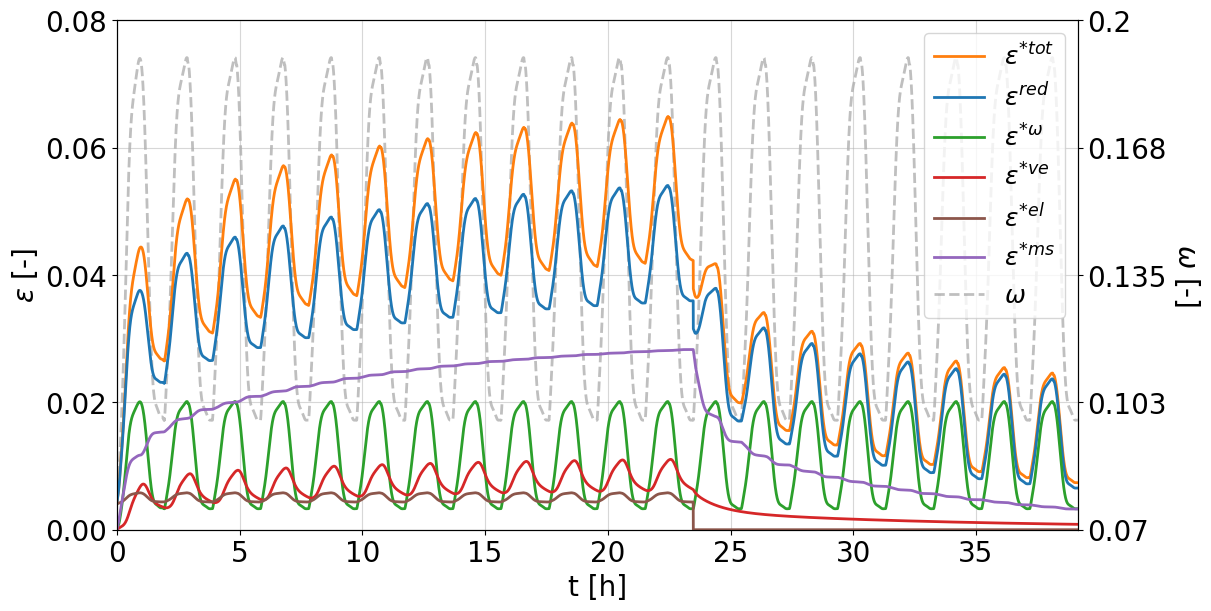

In [3]:
# Set inputs
sample_type = 'RL' # sample type
stress = 2. # applied stress [MPa]
comp_j = np.array([1., 6., 8.]) / 1000. # [1/MPa] KV-element compliances of mechanosorptive model

# Load moisture data from DVS test
data = np.load(dvs_path)
wdata0 = data['w'][0] # moisture [-] of 1st cycle (different sorption)
wdata = data['w'][1] # moisture [-] of following cycles (identical sorption/desorption)
tdata0 = data['t'][0] # time [h] of 1st cycle
tdata = data['t'][1] # time [h] of followng cycles

# Build moisture cycles with corresponding stress
total_cycles = 20 # total number of cycles
stressed_cycles = 12 # number of cycles under stress (the remaining ones are set with stress = 0)
t_full, w_full, s_full = build_cycles_with_initial(tdata0, wdata0, tdata,  wdata, total_cycles, stress, stressed_cycles)

# Build and plot strain components
fig, ax1 = plt.subplots(figsize=(12, 6), constrained_layout=True)
ax2 = ax1.twinx()
eps_full, ax1, ax2 = plot_built_strain_components(ax1, ax2, sample_type, t_full, w_full, s_full, comp_j)

# Show plot
plt.show()

### Calculate mechanosorptive strain from total strain using the incremental decomposition scheme

The incremental decomposition scheme to extract the mechanosorptive strain $\varepsilon^{ms}_{inc}$ from the total strain $\varepsilon^{tot}$ is based on constructing templates $\Theta$ from the reduced strain $\varepsilon^{red}$, which represent the repeating hygro-elastic strain $\varepsilon^{\omega + el}$ per cycle.

#### 1) Calculate strain templates and mechanosorptive strain of the 1st cycle
Run the following section to plot the strain templates:  
- $\Theta^{II}$ for all cycles under load from the 2nd cycle onward, and  
- $\Theta^{I}$ for the 1st cycle (different sorption phase),  

together with the resulting mechanosorptive strain of the 1st cycle $\varepsilon^{ms}(P_1)$.  

Specify the first and last cycles to average $\varepsilon^{red}$ into $\overline{\varepsilon}^{red}$ for the calculation of:  
- the strain template $\Theta^{II}$ under load, and  
- the strain template $\Theta^{III}$ for unloading.  

The plot axes and legend can be customized as needed.

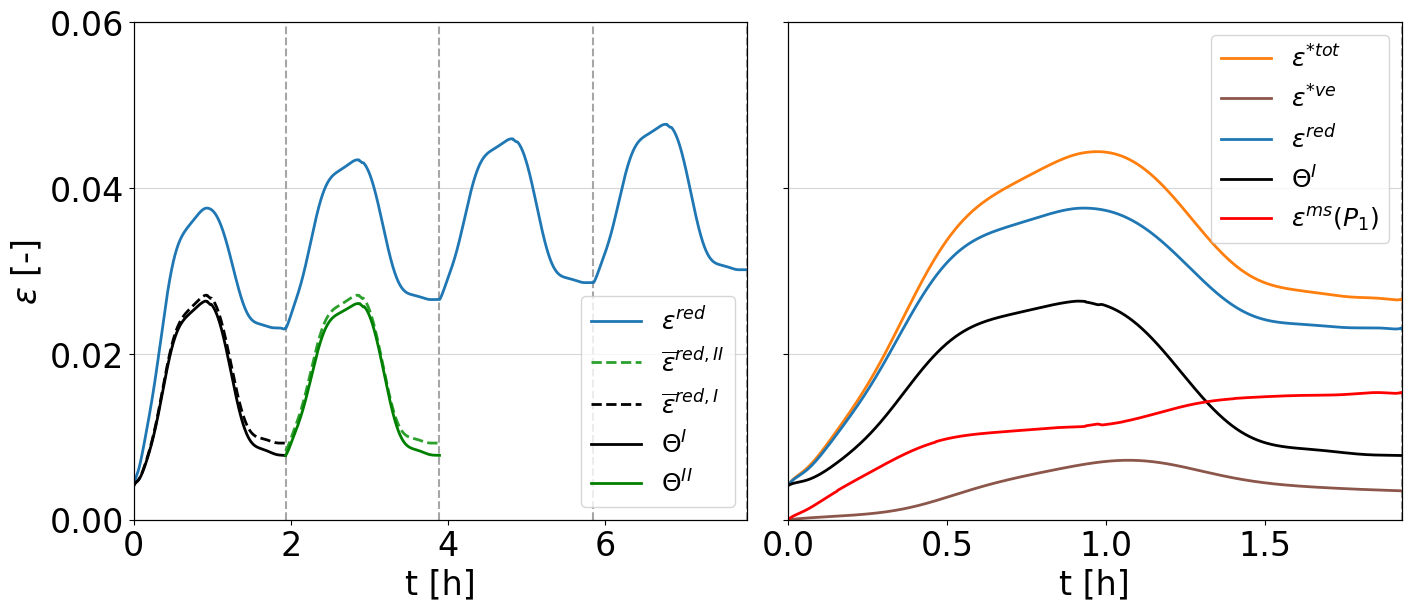

In [4]:
# Set cycles for templates calculation
firstc_load = 4   # first cycle for loading template
lastc_load  = 10  # last cycle for loading template
firstc_un   = -5  # first cycle for unloading template
lastc_un    = -1  # last cycle for unloading template

# Prepare figure
fig, axs = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)
linewidth = 2

# --------------------
# Left subplot (strain templates)
# --------------------
axes_left = [axs[0], axs[0].twinx()] # set axes
cycle_idx = find_cycle_ends(w_full, total_cycles) # get indexes of cycle ends
eps_comp = calculate_strain_components(sample_type, w_full, t_full, s_full, eps_full) # calculate strain components from total strain
eps_ref = eps_full - eps_comp[5] # calculate reference strain = total - viscoelastic
# Plot reduced strain
analyze_cycles(t_full, w_full, eps_ref, cycle_idx, firstc=firstc_load, lastc=lastc_load, ax=[axes_left[0]])
# Calculate and plot strain templates
times_flat, eps_flat, first_cycle, second_cycle, last_cycle, delta_eps, seg_times, _, _ = calculate_mechanosorptive_strain_from_inc(
        eps_comp[1], eps_comp[0], eps_comp[2], eps_ref, cycle_idx, firstc_load, lastc_load, firstc_un, lastc_un)
axes_left[0].plot(seg_times[0], first_cycle, '-', color='black', label=r'$\Theta^{I}$', linewidth=linewidth) # plot strain template of 1st cycle
axes_left[0].plot(seg_times[1], second_cycle + first_cycle[-1], '-', color='green', label=r'$\Theta^{II}$', linewidth=linewidth) # plot strain template of 2nd cycle on
axes_left[0].legend(loc='lower right', fontsize=18)
# Customize axes
axes_left[0].set_xlim(right=t_full[cycle_idx[3]])
axes_left[0].set_ylim(bottom=0, top=0.06) # set y-axis limit
axes_left[0].locator_params(axis='y', nbins=4)
axes_left[1].set_yticks([])

# --------------------
# Right subplot (zoom-in incremental scheme)
# --------------------
axes_right = [axs[1], axs[1].twinx()] # set axes
# Plot strain decomposition of 1st cycle
plot_incremental_scheme([axes_right[0]], sample_type, w_full, t_full, s_full, eps_full, cycle_idx, firstc_load, lastc_load, firstc_un, lastc_un)
# Customize axes
match_tick_values(axes_left[0], axes_right[0], axis='y')
for ax in axes_right:
        ax.set_yticklabels([])
        ax.set_ylabel('')
axes_right[1].set_yticks([])
axes_right[0].set_xlim(right=t_full[cycle_idx[0]])
# Customize legend
handles, labels = axes_right[0].get_legend_handles_labels()
axes_right[0].legend(handles[:-1], labels[:-1], loc='upper right', fontsize=18)

# Show plot
plt.show()

#### 2) Calculate mechanosorptive strain from the 2nd cycle onward
The mechanosorptive strain $\varepsilon^{ms}_{inc}$ for each cycle is obtained by subtracting the corresponding template from the reduced strain $\varepsilon^{red}$: $\Theta^{I}$ for the 1st cycle, $\Theta^{II}$ for all subsequent loading cycles, and $\Theta^{III}$ for unloading.  

Run the following section to plot the resulting $\varepsilon^{ms}$ together with its Kelvin–Voigt model fit, and compare it with the calculated mechanosorptive strain $\varepsilon^{*ms}$.

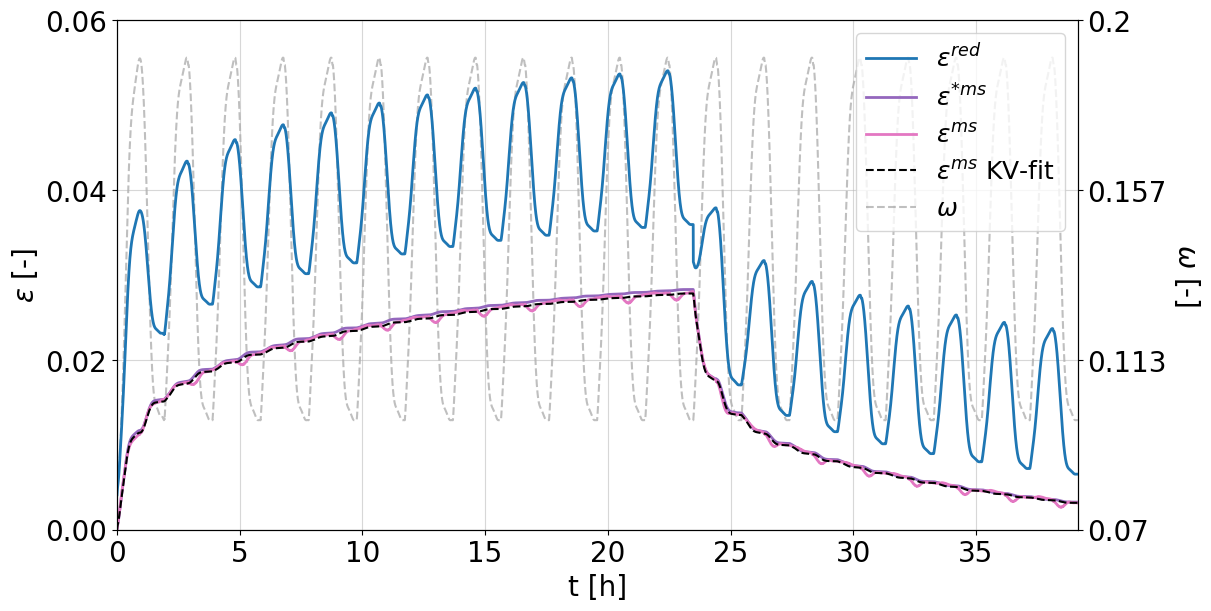

In [5]:
# Prepare figure
fig, ax_plot = plt.subplots(1,1,figsize=(12,6), constrained_layout=True)
axes = [ax_plot, ax_plot.twinx()]

# Plot mechanosorptive strain
plot_mechanosorptive_strains([axes[0], axes[1]], sample_type, w_full, t_full, s_full, eps_full, cycle_idx, firstc_load, lastc_load, firstc_un, lastc_un)

# Customize axes
match_tick_values(axes_left[0], axes[0], axis='y')
set_shared_grid(axes[0], axes[1])

# Show plot
plt.show()